In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import jax
import jax.numpy as jnp
from functools import partial
import plotting

from manifold import mirror_vecs, geodesic, dist_sq_arr
from sphere import Sphere as S, proj_comp
from bures_wasserstein import BuresWasserstein as BW, sym

import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "paper", rc={"axes.legendsize": 20, "axes.labelsize": 20, "axes.xtickssize": 20}
)


def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


alpha = 0.05
num_bootstrap = 1000
mc_repeats = 500


@partial(jax.jit, static_argnums=(0, 1, 2))
def proc_inner(M, n, sampler, sampler_args, mu_0, key):
    x_key, fm_key, key = jax.random.split(key, 3)

    x = sampler(x_key, n, *sampler_args)
    x_mirrored = mirror_vecs(M, mu_0, x)

    mu_hat = M.frechet_mean(x, fm_key)
    t = dist_sq_arr(M, mu_hat, x).mean()

    def fun(it_key):
        z_key, fm_key = jax.random.split(it_key)
        x_b = mixture(z_key, x, x_mirrored, 1 / 2)
        mu_hat_b = M.frechet_mean(x_b, fm_key)
        return dist_sq_arr(M, mu_hat_b, x_b).mean()

    t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))

    return jnp.mean(t > t_b) < alpha


def eval_test_mc(M, n, sampler, sampler_args, mu_0):
    key = jax.random.PRNGKey(np.random.randint(0, 2**32))
    subkeys = jax.random.split(key, mc_repeats)
    rejects = jax.vmap(lambda key: proc_inner(M, n, sampler, sampler_args, mu_0, key))(
        subkeys
    )
    return rejects.mean(), rejects.std()

# Book

100


  0%|          | 0/11 [00:00<?, ?it/s]

200


  0%|          | 0/11 [00:00<?, ?it/s]

400


  0%|          | 0/11 [00:00<?, ?it/s]

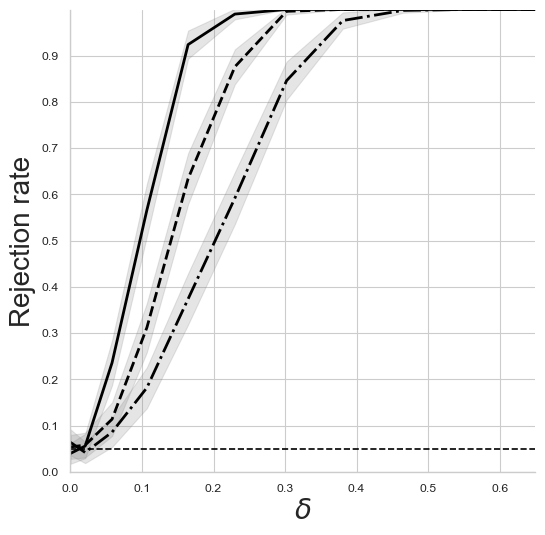

In [ ]:
import book

Book = book.Book(2)


@partial(jax.jit, static_argnums=(1,))
def book_sample(key, n, ps):
    assert ps.shape[0] == 4

    ps = ps / jnp.sum(ps)

    k1, k2, k3, k4, k5, k6 = jax.random.split(key, 6)

    ks = jax.random.choice(k1, ps.shape[0], shape=(n,), p=ps)

    xs = jnp.column_stack(
        [
            jax.random.beta(k2, 5, 20, shape=(n,)),
            jax.random.beta(k3, 20, 5, shape=(n,)),
            jax.random.beta(k4, 20, 5, shape=(n,)),
            jax.random.beta(k5, 20, 5, shape=(n,)),
        ]
    )

    ys = jax.random.normal(k6, shape=(n, Book.K - 1)) + jnp.ones(Book.K - 1)
    chosen_xs = xs[jnp.arange(n), ks]

    return jnp.column_stack([ks, chosen_xs, ys])


def book_eval_test_mc(Book, n, ps, mu_0):
    @partial(
        jax.jit,
        static_argnums=(
            0,
            1,
        ),
    )
    def proc_inner(Book, n, ps, mu_0, key):
        x_key, fm_key, key = jax.random.split(key, 3)

        x = book_sample(x_key, n, ps)
        x_mirrored = Book.reflect(mu_0, x)

        mu_hat = Book.frechet_mean(x, fm_key)
        t = dist_sq_arr(Book, mu_hat, x).mean()

        def fun(it_key):
            z_key, fm_key = jax.random.split(it_key)
            x_b = mixture(z_key, x, x_mirrored, 1 / 2)
            mu_hat_b = Book.frechet_mean(x_b, fm_key)
            return dist_sq_arr(Book, mu_hat_b, x_b).mean()

        t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))

        return jnp.mean(t > t_b) < alpha

    key = jax.random.PRNGKey(np.random.randint(0, 2**32))

    subkeys = jax.random.split(key, mc_repeats)

    rejects = jax.vmap(lambda key: proc_inner(Book, n, ps, mu_0, key))(subkeys)
    return rejects.mean(), rejects.std()


mu_0 = jnp.array([0, 0, 1])
mu_1 = jnp.array([1, 1, 0])

mu_delta = lambda t: mu_0 if t == 0 else jnp.array([1, t, 1 - t])
ps = jnp.array([4, 1, 1, 1]) / 7

delta_rates = np.zeros(11)
delta_rates_std = np.zeros(11)
_x = np.linspace(0, 1, delta_rates.shape[0])
deltas = 0.65 * _x**1.5
np.save(f"book_deltas.npy", deltas)

for n in [100, 200, 400]:
    print(n)
    for i, delta in tqdm(list(enumerate(deltas))):
        rm, rs = book_eval_test_mc(Book, n, ps, mu_delta(delta))
        delta_rates[i] = rm
        delta_rates_std[i] = rs

    np.save(f"sim_results/book_delta_rates_{n}.npy", delta_rates)
    np.save(f"sim_results/book_delta_rates_std_{n}.npy", delta_rates_std)

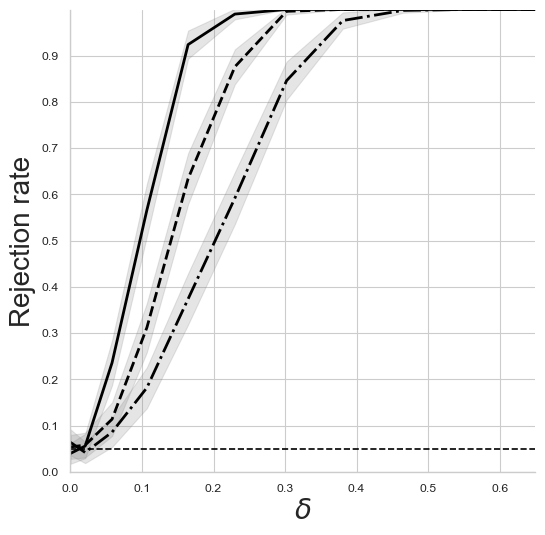

In [6]:
plotting.plot_sizes("sim_results/book", mc_repeats, out="./plots/booklet_size.pdf")

# Spherical Gaussian

In [2]:
@partial(jax.jit, static_argnums=(1,))
def sample_von_mises(key, n, mu):
    vs = 0.2 * jax.random.normal(key, (n, mu.shape[0]))
    return jax.vmap(lambda v: S.exp(mu, proj_comp(mu, v)))(vs)


mu_0 = jnp.array([0.0, 1.0])
mu_1 = jnp.array([1.0, 0.0])
mu_delta = lambda delta: geodesic(S, mu_0, mu_1, delta)

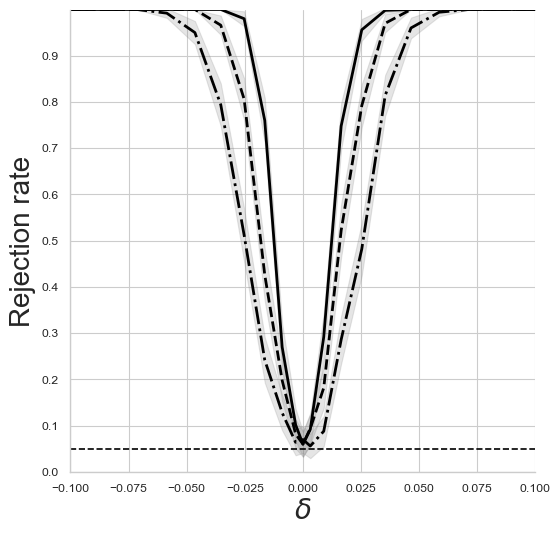

In [4]:
delta_rates = np.zeros(21)
delta_rates_std = np.zeros(21)
_x = np.linspace(-1, 1, delta_rates.shape[0])
deltas = 0.1 * np.sign(_x) * (np.abs(_x) ** 1.5)
np.save(f"circle_vm_deltas.npy", deltas)

for n in [100, 200, 400]:
    print(n)
    for i, delta in tqdm(enumerate(deltas)):
        rm, rs = eval_test_mc(S, n, sample_von_mises, (mu_delta(delta),), mu_0)
        delta_rates[i] = rm
        delta_rates_std[i] = rs

    np.save(f"circle_vm_delta_rates_{n}.npy", delta_rates)
    np.save(f"circle_vm_delta_rates_std_{n}.npy", delta_rates_std)

plotting.plot_sizes(
    "sim_results/circle_vm", mc_repeats, out="./plots/circle_vm_size.pdf"
)

  0%|          | 0/4 [00:00<?, ?it/s]

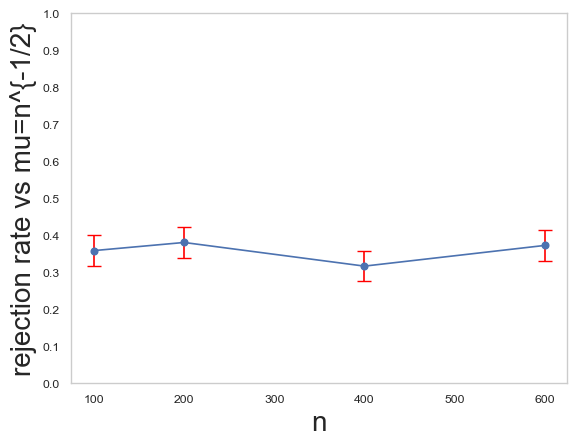

In [11]:
ns = [100, 200, 400, 600]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))

for i, n_i in tqdm(list(enumerate(ns))):
    rm, rs = eval_test_mc(
        S, n_i, sample_von_mises, (mu_delta(0.2 / np.power(n_i, 0.5)),), mu_0
    )
    local_rates[i] = rm
    local_rates_std[i] = rs

np.save(f"sim_results/circle_vm_ns.npy", ns)
np.save(f"sim_results/circle_vm_local_power.npy", local_rates)
np.save(f"sim_results/circle_vm_local_power_std.npy", local_rates_std)

plt.errorbar(
    ns,
    local_rates,
    yerr=local_rates_std * 1.96 / np.sqrt(mc_repeats),
    fmt="o-",
    ecolor="red",
    capsize=5,
    label="Rejection ± 95% CI",
)

plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("n")
plt.ylabel("rejection rate vs mu=n^{-1/2}")
plt.grid()

# Mixture of Spherical Gaussians

In [17]:
@partial(jax.jit, static_argnums=(1,))
def sample_mixture(key, n, mu0, mu1, p):
    key_z, key_x0, key_x1 = jax.random.split(key, 3)
    x0 = sample_von_mises(key_x0, n, mu0)
    x1 = sample_von_mises(key_x1, n, mu1)
    return mixture(key_z, x0, x1, p)


# sampling from a mixture of two gaussians with mean angles 0 and pi/2 and mixture weight 1/3
# the sample mean is then the angle pi/6
mix_mu_0 = jnp.array([0.0, 1.0])
mix_mu_1 = jnp.array([1.0, 0.0])
p = 1 / 3
mu_0 = geodesic(S, mix_mu_0, mix_mu_1, p)
mu_1 = jnp.array([1.0, 0.0])

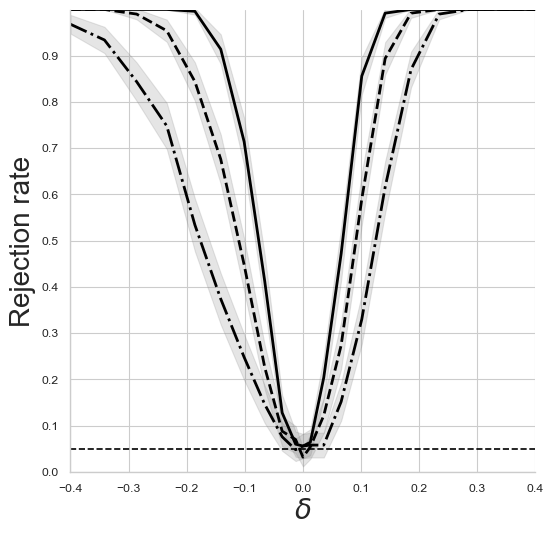

In [15]:
delta_rates = np.zeros(21)
delta_rates_std = np.zeros(delta_rates.shape[0])
_x = np.linspace(-1, 1, delta_rates.shape[0])
deltas = 0.4 * np.sign(_x) * (np.abs(_x) ** 1.5)
np.save(f"circle_mix_deltas.npy", deltas)

for n in [100, 200, 400]:
    print(n)

    for i, delta in tqdm(enumerate(deltas)):
        sampler_args = (
            geodesic(S, mix_mu_0, mu_1, delta),
            geodesic(S, mix_mu_1, mu_1, delta),
            p,
        )
        rm, rs = eval_test_mc(S, n, sample_mixture, sampler_args, mu_0)
        delta_rates[i] = rm
        delta_rates_std[i] = rs

    np.save(f"circle_mix_delta_rates_{n}.npy", delta_rates)
    np.save(f"circle_mix_delta_rates_std_{n}.npy", delta_rates_std)

plotting.plot_sizes(
    "sim_results/circle_mix", mc_repeats, out="./plots/circle_mix_size.pdf"
)

In [ ]:
ns = [100, 200, 400, 600]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))

for i, n_i in tqdm(list(enumerate(ns))):
    delta = 1 / np.sqrt(n_i)
    sampler_args = (
        geodesic(S, mix_mu_0, mu_1, delta),
        geodesic(S, mix_mu_1, mu_1, delta),
        p,
    )
    rm, rs = eval_test_mc(S, n_i, sample_mixture, sampler_args, mu_0)
    local_rates[i] = rm
    local_rates_std[i] = rs

np.save(f"sim_results/circle_mix_ns.npy", ns)
np.save(f"sim_results/circle_mix_local_power.npy", local_rates)
np.save(f"sim_results/circle_mix_local_power_std.npy", local_rates_std)

# Bures-Wasserstein

In [20]:
@partial(jax.jit, static_argnums=(1,))
def sample(key, n, mu):
    A = jnp.sqrt(0.1) * jax.random.normal(key, (n, mu.shape[0], mu.shape[0]))
    return jax.vmap(lambda A: BW.exp(mu, sym(A)))(A)


mu_0 = jnp.eye(2)
mu_1 = jnp.array([[4, 1], [1, 3]])
mu_delta = lambda delta: geodesic(BW, mu_0, mu_1, delta)

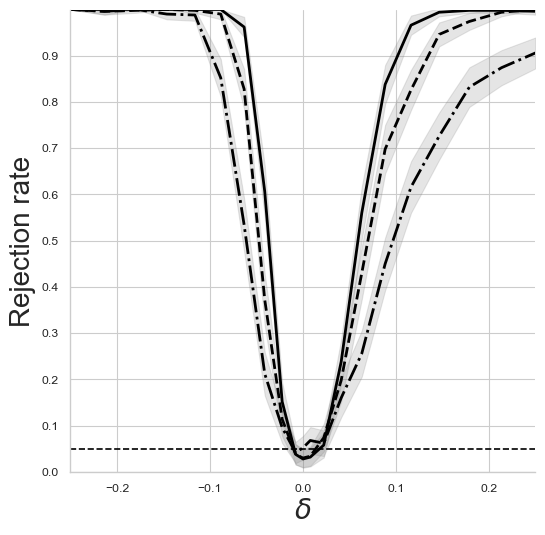

In [16]:
delta_rates = np.zeros(21)
delta_rates_std = np.zeros(delta_rates.shape[0])
_x = np.linspace(-1, 1, delta_rates.shape[0])
deltas = 0.25 * np.sign(_x) * (np.abs(_x) ** 1.5)
np.save(f"bw_deltas.npy", deltas)

for n in [100, 200, 400]:
    print(n)

    for i, delta in tqdm(enumerate(deltas)):
        rm, rs = eval_test_mc(BW, n, sample, (mu_delta(delta),), mu_0)
        delta_rates[i] = rm
        delta_rates_std[i] = rs

    np.save(f"bw_delta_rates_{n}.npy", delta_rates)
    np.save(f"bw_delta_rates_std_{n}.npy", delta_rates_std)

plotting.plot_sizes("sim_results/bw", mc_repeats, out="./plots/bw_size.pdf")

  0%|          | 0/4 [00:00<?, ?it/s]

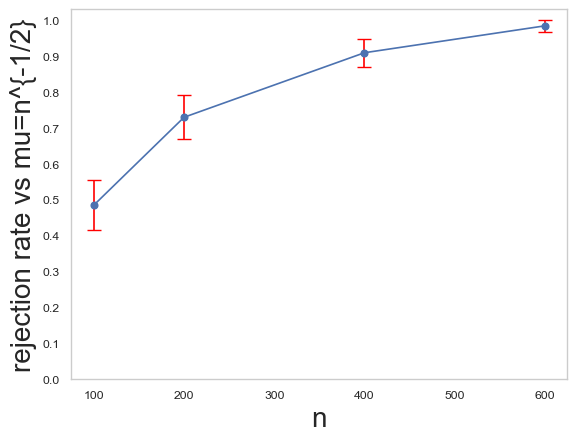

In [30]:
mc_repeats = 200

ns = [100, 200, 400, 600]
local_rates = np.zeros(len(ns))
local_rates_std = np.zeros(len(ns))
for i, n_i in tqdm(list(enumerate(ns))):
    # rm, rs = eval_test_mc(BW, n_i, sample, (mu_delta(1 / np.sqrt(n_i)),), mu_0)
    rm, rs = eval_test_mc(BW, n_i, sample, (mu_delta(1 / 10),), mu_0)
    local_rates[i] = rm
    local_rates_std[i] = rs

np.save(f"sim_results/bw_ns.npy", ns)
np.save(f"sim_results/bw_local_power.npy", local_rates)
np.save(f"sim_results/bw_local_power_std.npy", local_rates_std)

plt.errorbar(
    ns,
    local_rates,
    yerr=local_rates_std * 1.96 / np.sqrt(mc_repeats),
    fmt="o-",
    ecolor="red",
    capsize=5,
    label="Rejection ± 95% CI",
)

plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("n")
plt.ylabel("rejection rate vs mu=n^{-1/2}")
plt.grid()

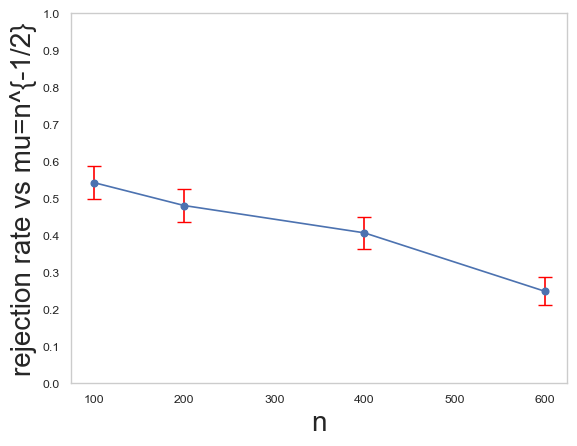